In [14]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Security
import getpass

# Miscellaneous
import warnings
import math
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)


In [15]:
import requests

def fetch_parameter_data(param, city, start_date, end_date, headers):
    """
    Fetches data for a specific parameter from the OpenAQ API.

    Parameters:
    - param (str): The pollutant parameter to fetch (e.g., 'pm25').
    - city (str): The city name.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - headers (dict): Headers containing the API key.

    Returns:
    - List of dictionaries containing datetime, parameter, and value.
    """
    base_url = "https://api.openaq.org/v2/measurements"
    params = {
        "city": city,
        "parameter": param,
        "date_from": start_date,
        "date_to": end_date,
        "limit": 10000,
        "page": 1
    }
    all_data = []
    while True:
        try:
            response = requests.get(base_url, params=params, headers=headers)
            response.raise_for_status()
            data = response.json()
            results = data.get('results', [])
            if not results:
                break
            for result in results:
                if 'date' in result and 'utc' in result['date']:
                    all_data.append({
                        'datetime': result['date']['utc'],
                        'parameter': result['parameter'],
                        'value': result['value']
                    })
                else:
                    print(f"Skipping a result due to missing 'date.utc': {result}")
            params['page'] += 1
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data for parameter {param}: {e}")
            break
    return all_data

def fetch_openaq_data_parallel(city, parameters, start_date, end_date, api_key):
    """
    Fetches data for multiple parameters in parallel using threading.

    Parameters:
    - city (str): The city name.
    - parameters (list): List of pollutant parameters to fetch.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - api_key (str): OpenAQ API key.

    Returns:
    - DataFrame with datetime as index and parameters as columns.
    """
    import concurrent.futures
    headers = {"X-API-Key": api_key}
    all_data = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(fetch_parameter_data, param, city, start_date, end_date, headers) for param in parameters]
        for future in concurrent.futures.as_completed(futures):
            data = future.result()
            all_data.extend(data)
    if all_data:
        df = pd.DataFrame(all_data)
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.pivot_table(values='value', index='datetime', columns='parameter', aggfunc='mean')
        df = df.resample('H').mean()
        return df
    else:
        return None


In [16]:
def create_sequences(data, time_steps=60, target_indices=None):
    """
    Creates input sequences and target outputs for LSTM.

    Parameters:
    - data (np.array): Scaled data array.
    - time_steps (int): Number of past time steps to include.
    - target_indices (list): Indices of target parameters.

    Returns:
    - X (np.array): Input sequences.
    - y (np.array): Target outputs.
    """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps][target_indices])
    return np.array(X), np.array(y)


In [17]:
def build_multi_output_model(input_shape, num_outputs):
    """
    Builds and compiles a multi-output LSTM model.

    Parameters:
    - input_shape (tuple): Shape of the input data (time_steps, features)
    - num_outputs (int): Number of output parameters to predict

    Returns:
    - model (Sequential): Compiled multi-output LSTM model
    """
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_outputs))  # Output layer for multiple regression targets
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [18]:
def plot_actual_vs_predicted(y_true, y_pred, parameter_name):
    """
    Plots Actual vs. Predicted values for a given parameter.

    Parameters:
    - y_true (np.array): True values.
    - y_pred (np.array): Predicted values.
    - parameter_name (str): Name of the parameter.
    """
    plt.figure(figsize=(15, 5))
    plt.plot(y_true, label=f'Actual {parameter_name.upper()}')
    plt.plot(y_pred, label=f'Predicted {parameter_name.upper()}')
    plt.title(f'Actual vs. Predicted {parameter_name.upper()} Levels')
    plt.xlabel('Time')
    plt.ylabel(f'{parameter_name.upper()} Concentration')
    plt.legend()
    plt.show()


Enter your OpenAQ API key: ··········
Enter the city name for air quality prediction: Madrid

Fetching data...
Error fetching data for parameter pm25: 500 Server Error: Internal Server Error for url: https://api.openaq.org/v2/measurements?city=Madrid&parameter=pm25&date_from=2023-11-02&date_to=2024-11-01&limit=10000&page=2
Data fetched successfully. Shape: (2132, 4)

Selected Features: ['no2', 'pm10', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'pm25_lag_4', 'pm25_lag_5', 'pm25_lag_6', 'pm25_lag_7', 'pm25_lag_8', 'pm25_lag_9', 'pm25_lag_10', 'pm25_lag_11', 'pm25_lag_17', 'pm25_lag_18', 'pm25_lag_19', 'pm25_lag_20', 'pm25_lag_21', 'pm25_lag_22', 'pm25_lag_23', 'pm25_lag_24', 'pm25_roll_mean_3']

Training sequences: (1626, 60, 26)
Testing sequences: (362, 60, 26)

Training the model...
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0318 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0141 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0103 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0097 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0081 - val_loss: 0.0086 - learning_rate: 0.0010
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0078 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 10/100
26/26 ━━━


Model training complete and saved as 'air_quality_multi_output_lstm_model.h5'.

Making predictions on test data...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Calculating evaluation metrics for each parameter...
PM25 - MSE: 5.37, RMSE: 2.32, MAE: 1.68, R²: 0.87
PM10 - MSE: 6.97, RMSE: 2.64, MAE: 1.88, R²: 0.93
NO2 - MSE: 9.44, RMSE: 3.07, MAE: 2.29, R²: 0.95
SO2 - MSE: 0.08, RMSE: 0.28, MAE: 0.17, R²: 0.63

Plotting Training and Validation Loss...


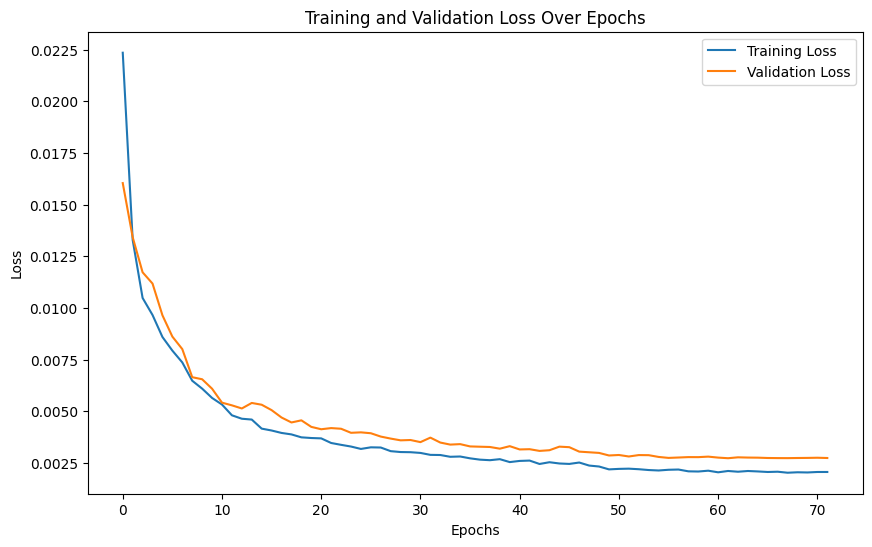


--- Plotting Actual vs. Predicted for PM25 ---


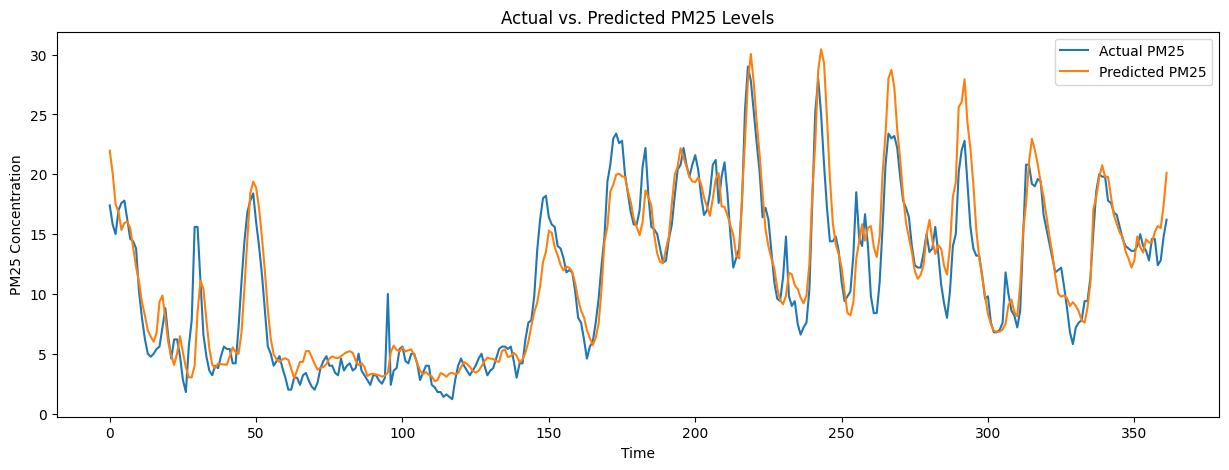


--- Plotting Actual vs. Predicted for PM10 ---


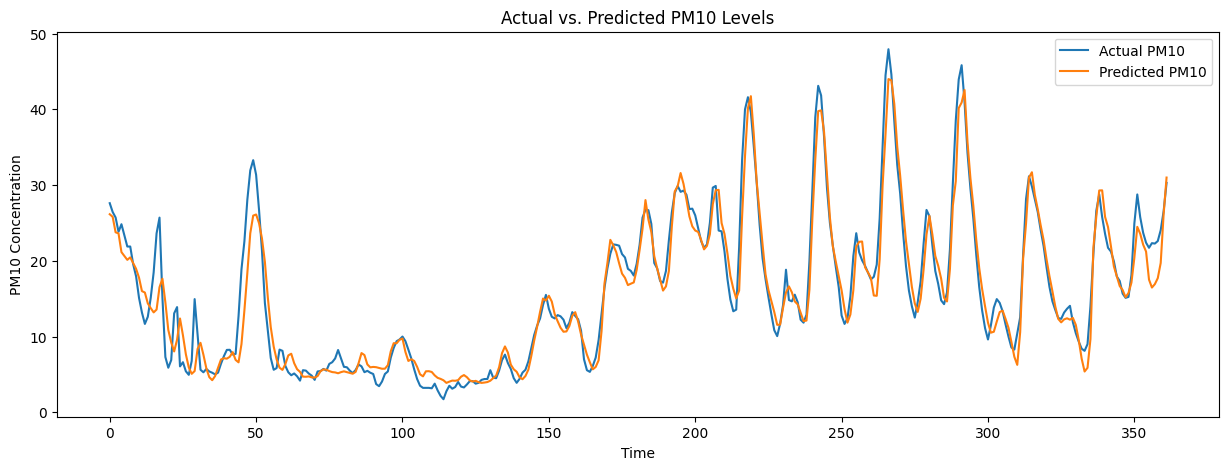


--- Plotting Actual vs. Predicted for NO2 ---


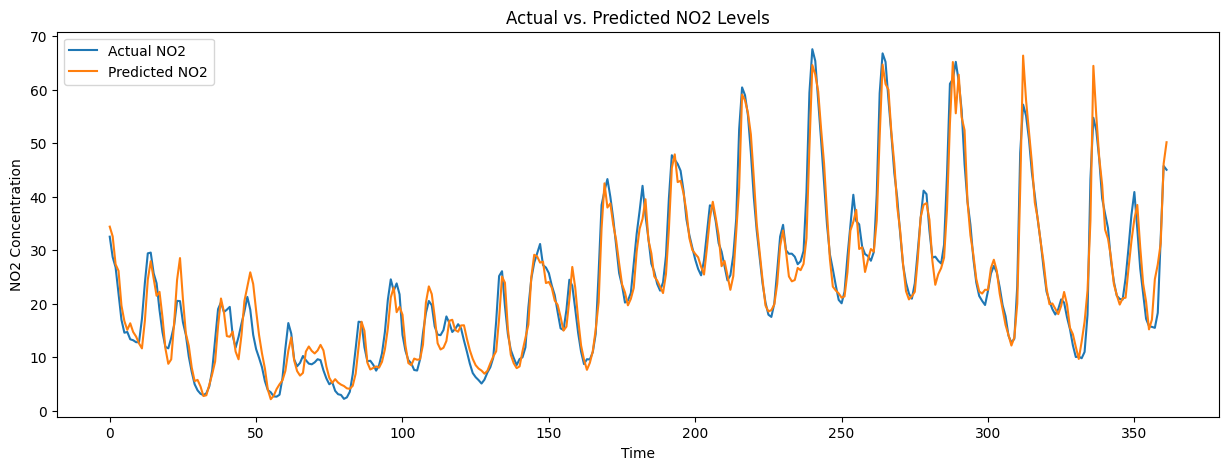


--- Plotting Actual vs. Predicted for SO2 ---


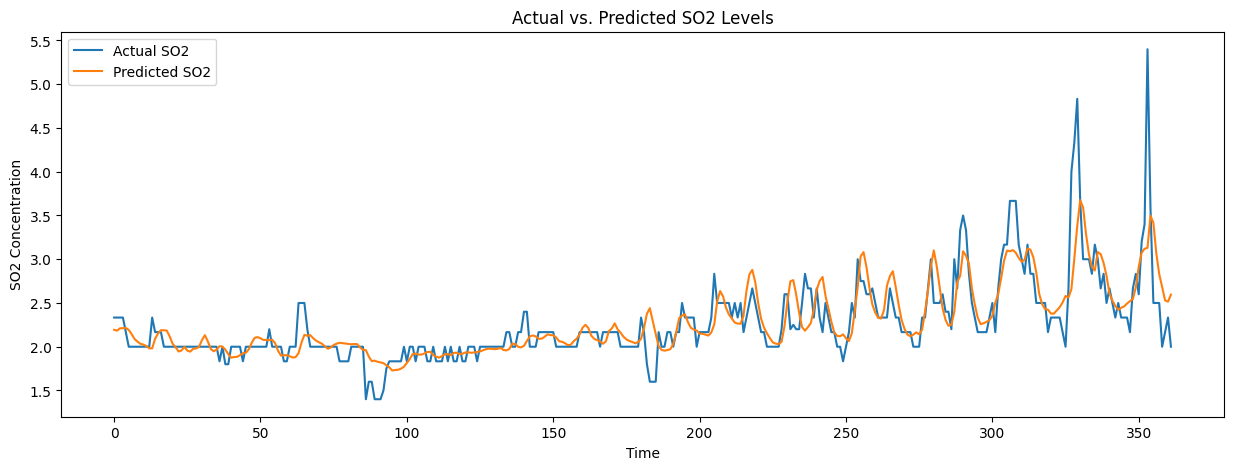

In [32]:
# Main Execution

# Prompt the user for the API key securely
api_key = getpass.getpass("Enter your OpenAQ API key: ")

# User Inputs
city_name = input("Enter the city name for air quality prediction: ")
parameters = ['pm25', 'pm10', 'no2', 'so2']  # Removed 'co' as per your request

# Validate Parameters
available_parameters = ['pm25', 'pm10', 'co', 'no2', 'so2']
for param in parameters:
    if param not in available_parameters:
        raise ValueError(f"Parameter '{param}' is not available. Choose from {available_parameters}.")

end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print("\nFetching data...")
df = fetch_openaq_data_parallel(
    city=city_name,
    parameters=parameters,
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d'),
    api_key=api_key
)

if df is not None and not df.empty:
    print(f"Data fetched successfully. Shape: {df.shape}")

    # Handle Missing Values
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    # Feature Engineering
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['season'] = df['month'] % 12 // 3 + 1  # 1: Winter, 2: Spring, etc.

    # Lag Features for PM2.5 (as an example)
    for lag in range(1, 25):
        df[f'pm25_lag_{lag}'] = df['pm25'].shift(lag)

    # Rolling Statistics
    df['pm25_roll_mean_3'] = df['pm25'].rolling(window=3).mean()
    df['pm25_roll_std_3'] = df['pm25'].rolling(window=3).std()

    # Interaction Features
    df['pm25_pm10_ratio'] = df['pm25'] / (df['pm10'] + 1e-5)  # Avoid division by zero

    # Drop rows with NaN values introduced by lagging and rolling
    df.dropna(inplace=True)

    # Feature Selection based on correlation with PM2.5
    target = 'pm25'
    correlation_threshold = 0.5
    correlated_features = df.corr()[target].abs()
    selected_features = correlated_features[correlated_features > correlation_threshold].index.tolist()
    selected_features.remove(target)  # Remove target itself
    print("\nSelected Features:", selected_features)

    # Final feature set including all parameters to predict
    features = selected_features + parameters  # ['pm10', 'pm25_lag_1', ..., 'so2']

    # Check if all features are present in the DataFrame
    missing_features = [feat for feat in features if feat not in df.columns]
    if missing_features:
        print(f"Warning: The following features are missing from the data and will be excluded: {missing_features}")
        features = [feat for feat in features if feat in df.columns]

    df = df[features]

    # Scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df)
    joblib.dump(scaler, 'scaler_multi.save')  # Save the scaler for future use

    # Train-Test Split
    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Define target indices for multi-output
    target_indices = [features.index(param) for param in parameters]

    # Creating Sequences
    TIME_STEPS = 60
    X_train, y_train = create_sequences(train, TIME_STEPS, target_indices)
    X_test, y_test = create_sequences(test, TIME_STEPS, target_indices)

    print("\nTraining sequences:", X_train.shape)
    print("Testing sequences:", X_test.shape)

    # Build the Multi-Output LSTM Model
    num_outputs = len(parameters)
    model = build_multi_output_model((X_train.shape[1], X_train.shape[2]), num_outputs)

    # Define Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

    # Train the Model
    print("\nTraining the model...")
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, lr_scheduler],
        verbose=1
    )

    # Save the Model
    model.save('air_quality_multi_output_lstm_model.h5')
    print("\nModel training complete and saved as 'air_quality_multi_output_lstm_model.h5'.")

    # Evaluate the Model
    # Make Predictions
    print("\nMaking predictions on test data...")
    multi_predictions = model.predict(X_test)

    # Inverse Transform Predictions and True Values
    scaler = joblib.load('scaler_multi.save')
    # Create a zero array for inverse transform
    predictions_scaled = np.zeros((multi_predictions.shape[0], scaled_data.shape[1]))
    predictions_scaled[:, target_indices] = multi_predictions
    predictions_inverse = scaler.inverse_transform(predictions_scaled)[:, target_indices]

    # Similarly, inverse transform y_test
    y_test_scaled_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))
    y_test_scaled_full[:, target_indices] = y_test
    y_test_inverse = scaler.inverse_transform(y_test_scaled_full)[:, target_indices]

    # Calculate Metrics for Each Parameter
    print("\nCalculating evaluation metrics for each parameter...")
    metrics_multi = {}
    for idx, param in enumerate(parameters):
        mse = mean_squared_error(y_test_inverse[:, idx], predictions_inverse[:, idx])
        rmse = math.sqrt(mse)
        mae = mean_absolute_error(y_test_inverse[:, idx], predictions_inverse[:, idx])
        r2 = r2_score(y_test_inverse[:, idx], predictions_inverse[:, idx])

        metrics_multi[param] = {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}
        print(f"{param.upper()} - MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")

    # Plot Training and Validation Loss
    print("\nPlotting Training and Validation Loss...")
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Actual vs Predicted for Each Parameter
    for idx, param in enumerate(parameters):
        print(f"\n--- Plotting Actual vs. Predicted for {param.upper()} ---")
        y_true = y_test_inverse[:, idx]
        y_pred = predictions_inverse[:, idx]
        plot_actual_vs_predicted(y_true, y_pred, param)
else:
    print(f"Failed to fetch data or no data available for {city_name}.")
    print("Please check your API key and ensure that data is available for the specified city and date range.")
